In [148]:
from src.gym_cpr_grid.gym_cpr_grid.cpr_grid import CPRGridEnv, AgentOrientation
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
env = CPRGridEnv(n_agents=3, grid_width=5, grid_height=7)

In [29]:
env.grid

array([[1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 2, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 2, 0, 2]])

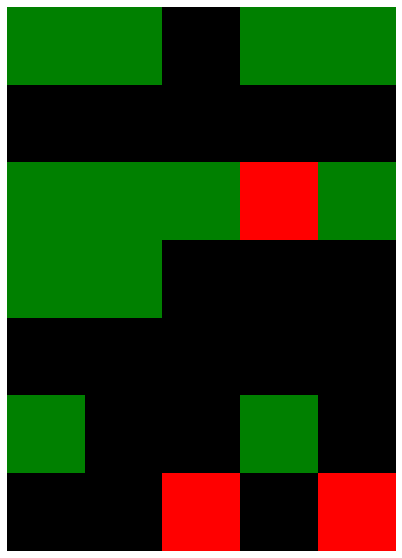

In [30]:
env.render()

In [31]:
env.agent_positions

[AgentPosition(4, 6, 0), AgentPosition(2, 6, 1), AgentPosition(3, 2, 2)]

In [36]:
(env.agent_positions[0].x,
env.agent_positions[0].y,
env.fov_squares_side,
env.fov_squares_front)

(4, 6, 10, 20)

In [38]:
env.grid

array([[1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 2, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 2, 0, 2]])

In [37]:
env._pad_grid(
    env.agent_positions[0].x,
    env.agent_positions[0].y,
    env.fov_squares_side,
    env.fov_squares_front,
)

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [92]:
env.grid

array([[1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [1, 1, 1, 2, 1],
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 2, 0, 2]])

In [137]:
np.rot90(env.grid, k=3)

array([[0, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 0, 1],
       [2, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 2, 0, 1],
       [2, 0, 0, 0, 1, 0, 1]])

In [129]:
import itertools

coords=list(itertools.product(range(env.grid_height), range(env.grid_width)))
a=np.array(coords).reshape(env.grid_height, env.grid_width, 2)
b=np.rot90(a, k=3)

In [184]:
env.agent_positions[1]

AgentPosition(2, 6, 1)

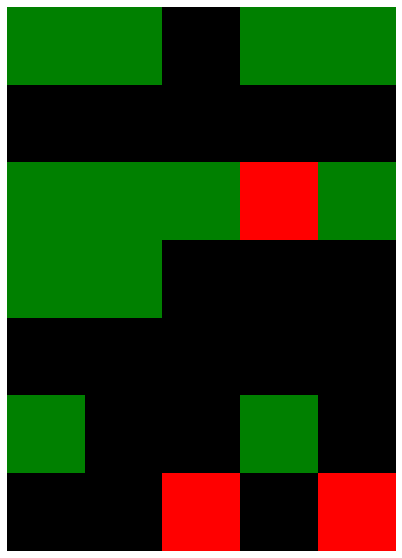

In [185]:
env.render()

In [131]:
x, y = env.agent_positions[1].x, env.agent_positions[1].y
x, y=np.argwhere((b[:, :, 0]==y) & (b[:,:,1]==x))[0]
x, y

(2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


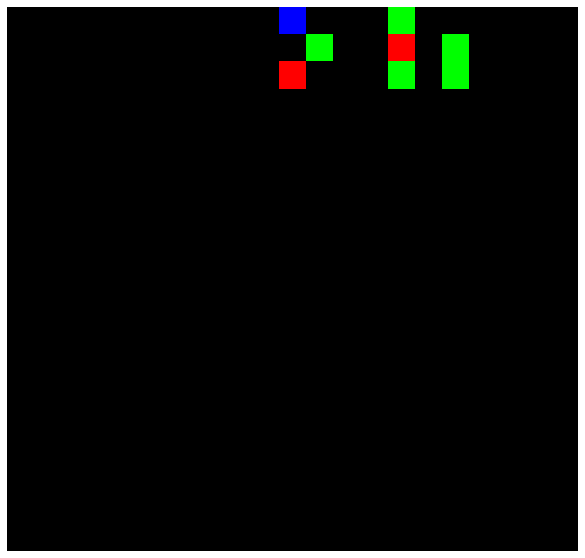

In [187]:
o=env._get_observation(1)
env.plot_observation(o)

In [169]:
o[env.fov_squares_side, 0]

array([0., 0., 0.])

In [ ]:
# Convert the FOV to 3 channels
fov = np.stack((fov,) * 3, axis=-1)

# Set a different color for the agent that we are computing the FOV for
fov[self.fov_squares_side, 0] = colors.to_rgb(self.FOV_OWN_AGENT_COLOR)

# Set colors for resources and other agents
fov[fov == GridCell.RESOURCE] = colors.to_rgb(
    self.GRID_CELL_COLORS[GridCell.RESOURCE]
)
fov[fov == GridCell.AGENT] = colors.to_rgb(
    self.GRID_CELL_COLORS[GridCell.AGENT]
)

In [24]:
import numpy as np
import gym

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
!pip install src/gym_cpr_grid

Processing ./src/gym_cpr_grid
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for gym-cpr-grid: filename=gym_cpr_grid-0.0.1-py3-none-any.whl size=6150 sha256=bca8f0d6850d8245d3360258cb59899d077686dc2f299e9af3341d30bc8b9cc2
  Stored in directory: /private/var/folders/pp/wfj1kcws58g7pxksj9k8zdhw0000gn/T/pip-ephem-wheel-cache-e46mo1fi/wheels/15/b8/5e/e8cf71a4e081d3ad152d040fd0d82eab5c70e705c5b2f60c6b
Successfully built gym-cpr-grid
  Attempting uninstall: gym-cpr-grid
    Found existing installation: gym-cpr-grid 0.0.1
    Uninstalling gym-cpr-grid-0.0.1:
      Successfully uninstalled gym-cpr-grid-0.0.1


In [180]:
env = gym.make('gym_cpr_grid:CPRGridEnv-v0', n_agents=3, grid_width=5, grid_height=7)

In [181]:
env.COLOR_BOUNDARIES.boundaries

array([0, 1, 2, 3])

In [182]:
env.grid

array([[1, 1, 1, 0, 1],
       [2, 1, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [2, 0, 0, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 2, 0, 0, 0],
       [0, 1, 1, 0, 0]])

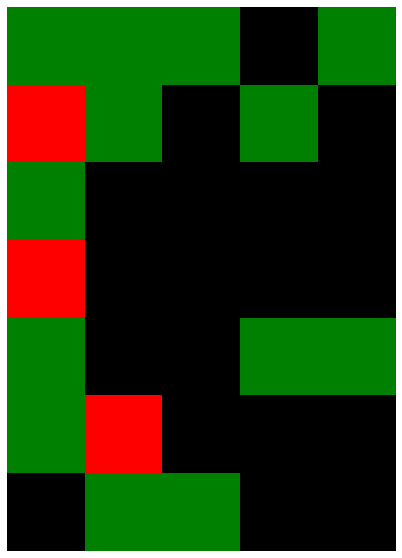

In [183]:
env.render()

Error: Cannot re-register id: CPRGridEnv-v0

In [193]:
env.agent_positions

[AgentPosition(1, 5, 3), AgentPosition(0, 3, 1), AgentPosition(0, 1, 3)]

In [174]:
env.step([env.action_space.sample() for _ in range(3)])

AssertionError: There was an error in FOV extraction, incorrect shape

In [186]:
env.grid

array([[1, 1, 1, 0, 1],
       [2, 1, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [2, 0, 0, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 2, 0, 0, 0],
       [0, 1, 1, 0, 0]])

In [188]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

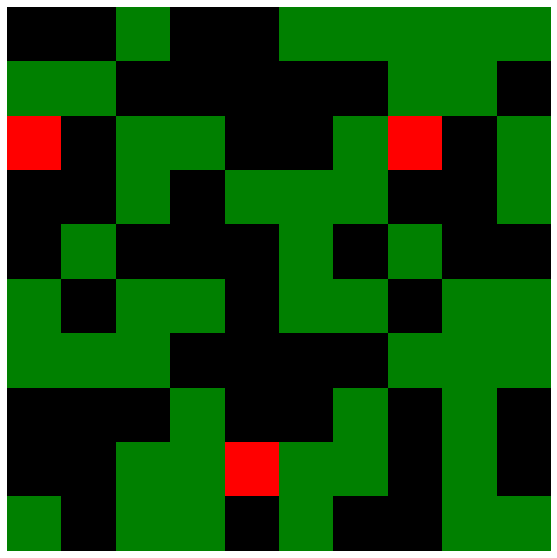

AssertionError: The given action must be an instance of AgentAction

In [113]:
for _ in range(1000):
    env.render()
    env.step([env.action_space.sample() for _ in range(3)])
env.close()

In [157]:
resource_mask = np.random.randint(
    low=0, high=2, size=(5, 10), dtype=bool
)
resource_mask

array([[False, False, False, False, False,  True,  True, False,  True,
        False],
       [ True,  True,  True, False,  True, False,  True, False, False,
         True],
       [False, False,  True, False, False,  True,  True,  True,  True,
        False],
       [False, False, False, False, False,  True,  True,  True, False,
         True],
       [False,  True, False, False, False, False,  True,  True, False,
         True]])

In [158]:
xs, ys = resource_mask.nonzero()
list(zip(list(xs), list(ys)))

[(0, 5),
 (0, 6),
 (0, 8),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 4),
 (1, 6),
 (1, 9),
 (2, 2),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 6),
 (4, 7),
 (4, 9)]

In [3]:
radius =2
kernel = np.zeros((2*radius+1, 2*radius+1))
y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
mask = x**2 + y**2 <= radius**2
kernel[mask] = 1
kernel

array([[0., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [5]:
a = np.zeros((5,5))
a[1,1] = 10
a[0,4] = 20
a

array([[ 0.,  0.,  0.,  0., 20.],
       [ 0., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [7]:
a[kernel.astype(bool)]

array([ 0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [20]:
v = []
for _ in range(100):
    v += [np.random.binomial(1, 0.1)]
    if v[-1]:
        print('cioa')
len([x for x in v if x == 1])

cioa
cioa
cioa
cioa
cioa
cioa
cioa


7